# Продвинутое машинное обучение:
# Домашнее задание 2

**Стариков Андрей**  
MADE ML-22

## 1. Прочитайте и проанализируйте данные.
Выберите турниры, в которых есть данные о составах команд и повопросных результатах (поле mask в results.pkl).

Для унификации предлагаю:
- взять в тренировочный набор турниры с dateStart из 2019 года; 
- в тестовый &mdash; турниры с dateStart из 2020 года.

In [1]:
import os
import re
import gc
import datetime
import requests
import pickle
import pytz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

from tqdm.notebook import tqdm

from scipy.stats import spearmanr, kendalltau
from scipy.sparse import lil_matrix, vstack, csr_matrix, csc_matrix
from scipy.special import logit, expit as sigmoid

from sklearn.linear_model import LogisticRegression, LinearRegression

tz_MSK = pytz.timezone('Europe/Moscow')

%matplotlib widget

In [2]:
tournaments = pickle.load(open('data/tournaments.pkl', 'rb'))
results = pickle.load(open('data/results.pkl', 'rb'))
players = pickle.load(open('data/players.pkl', 'rb'))

In [3]:
def parse_tournaments(year):
    data = [{'id': k,
             'name': v['name'],
             'date': datetime.datetime.fromisoformat(v['dateStart']),
             'questionQty': sum(v['questionQty'].values())}
                for k, v in tournaments.items() if (datetime.datetime.fromisoformat(v['dateStart']).astimezone(tz_MSK).year == year)]

    df = pd.DataFrame(data)
    df.set_index('id', drop=True, inplace=True)
    df.sort_values('date', inplace=True)
    return df

train_tour = parse_tournaments(2019)
val_tour = parse_tournaments(2020)

train_tour.head()

,name,date,questionQty
id,,,
5284,Гусарская лига. II сезон. III этап,2019-01-01 20:00:00+03:00,36
5266,Холодная голова,2019-01-04 12:00:00+03:00,90
5083,Ускользающая сова,2019-01-04 14:00:00+03:00,36
5103,Серия Premier. Громокипящий кубок,2019-01-04 19:00:00+03:00,36
5405,Кавалькада волхвов,2019-01-05 06:00:00+03:00,345


In [4]:
def parse_results(ids):
    data = []
    for id in ids:
        for team in results[id]:
            if ('mask' not in team) \
                or (team['mask'] is None):
                    continue

            team_position = team['position']
                    
            for player in team['teamMembers']:
                player = player['player']
                data.append({
                    'tournament_id': id,
                    'team_id': team['team']['id'],
                    'team_name': team['team']['name'],
                    'player_id': player['id'],
                    'team_position': team_position,
                    'player_name': f"{player['surname']} {player['name']} {player['patronymic']}",
                    'mask': team['mask'],
                    'mask_len': len(team['mask'])
                })
    df = pd.DataFrame(data)

    return df

train_res = parse_results(train_tour.index)
val_res = parse_results(val_tour.index)

print(train_res.shape, val_res.shape)

train_res.head()

(451783, 8) (112841, 8)


,tournament_id,team_id,team_name,player_id,team_position,player_name,mask,mask_len
0,5284,3730,Сдача бреда,117,1.5,Аботурова Марина Германовна,110111011010111100111111111011101111,36
1,5284,3730,Сдача бреда,87865,1.5,Буров Константин Олегович,110111011010111100111111111011101111,36
2,5284,3730,Сдача бреда,30672,1.5,Стриженко Татьяна Сергеевна,110111011010111100111111111011101111,36
3,5284,3730,Сдача бреда,35442,1.5,Шакиров Айрат Тагирович,110111011010111100111111111011101111,36
4,5284,3730,Сдача бреда,63465,1.5,Коптин Александр Борисович,110111011010111100111111111011101111,36


Отбросим команды, у которых длина маски ответа не совпадает с количеством вопросов на турнире.

In [5]:
tmp_data = train_res[['tournament_id', 'mask_len']].join(train_tour['questionQty'], on='tournament_id')
train_res = train_res[tmp_data.mask_len == tmp_data.questionQty]
del tmp_data

print(train_res.shape)

(414743, 8)


Проверим, что **X** и **?** стоит в маске в одинаковой позиции в одном туре.

In [6]:
for x in train_res.groupby('tournament_id'):
    m_X = None
    m_Q = None
    x_f = False
    x_q = False
    for m in x[1]['mask']:
        if m_X is None:
            m_X = [i for i, k in enumerate(m) if k=='X']
        if m_Q is None:
            m_Q = [i for i, k in enumerate(m) if k=='?']

        if not x_f and m_X != [i for i, k in enumerate(m) if k=='X']:
            x_f = True
            print('Маска Х нарушена в турнире', x[0])
        if not x_q and m_Q != [i for i, k in enumerate(m) if k=='?']:
            x_q = True
            print('Маска ? нарушена в турнире', x[0])

Маска ? нарушена в турнире 5141
Маска ? нарушена в турнире 5186
Маска ? нарушена в турнире 5563
Маска ? нарушена в турнире 5740
Маска ? нарушена в турнире 5827
Маска ? нарушена в турнире 5828
Маска ? нарушена в турнире 5845
Маска ? нарушена в турнире 5963
Маска ? нарушена в турнире 5991
Маска ? нарушена в турнире 6006


---
snikolenko — 15.03.2021, в 14:43  
предложил бы просто выкинуть нафиг все вопросы, в которых встречается "?" или "Х" (но не целые турниры, отдельные вопросы) "Х", кажется, как раз значит, что вопрос снят, и там "Х" должен быть у всех команд.
---

Удалим **X** и заменим **?** на 0 (дан неправильный ответ).

In [7]:
train_res['mask'] = train_res['mask'].str.replace('X', '', regex=False).str.replace('?', '0', regex=False)
train_res['mask_len'] = train_res['mask'].str.len()
TRAIN_PLAYERS = train_res.player_id.nunique()

qst_df = train_res.groupby(by='tournament_id').first().agg({'mask_len':'cumsum'}).reset_index()
TRAIN_QST = train_res.groupby(by='tournament_id').mask_len.max().sum()

qst_rows_df = train_res.agg({'mask_len':'cumsum'}).reset_index()
TOTAL_ROWS = qst_rows_df.tail(1).mask_len.values[0]

val_res['mask'] = val_res['mask'].str.replace('X', '', regex=False).str.replace('?', '0', regex=False)
val_res['mask_len'] = val_res['mask'].str.len()

assert TRAIN_QST == qst_df.tail(1).mask_len.values[0], 'Количество вопросов не совпадает'

print(f'Всего турниров: {train_res.tournament_id.nunique()}, игроков: {TRAIN_PLAYERS:_d}, уникальных вопросов: {TRAIN_QST:_d}, всего комбинаций участники/вопросы: {TOTAL_ROWS:_d}')

Всего турниров: 675, игроков: 57_429, уникальных вопросов: 33_299, всего комбинаций участники/вопросы: 17_739_943


In [8]:
players_idx = {v:k for k, v in enumerate(train_res.player_id.unique())}
players_id  = {v:k for k, v in players_idx.items()}

train_res['pid'] = train_res.player_id.apply(players_idx.get)
train_res.head(3)

,tournament_id,team_id,team_name,player_id,team_position,player_name,mask,mask_len,pid
0,5284,3730,Сдача бреда,117,1.5,Аботурова Марина Германовна,110111011010111100111111111011101111,36,0
1,5284,3730,Сдача бреда,87865,1.5,Буров Константин Олегович,110111011010111100111111111011101111,36,1
2,5284,3730,Сдача бреда,30672,1.5,Стриженко Татьяна Сергеевна,110111011010111100111111111011101111,36,2


In [9]:
team_players = train_res[['team_id', 'pid']].groupby('team_id').agg(set)
team_players.shape

(11420, 1)

## 2. Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков.
Замечания и подсказки:
- повопросные результаты &mdash; это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
- в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
- для baseline&ndash;модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.

Построим таблицу, в которой столбцами будут игроки и вопросы, таргетом &mdash; правильный/неправильный ответ (команды). Строками будет сочетание 1 игрок &mdash; 1 вопрос. Поскольку таких сочетаний будет много и столбцов тоже будет много, матрицу будем строить разреженную (csr): сначала будут игроки, потом &mdash; вопросы.

Обозначим игрока как $i$, его уровень как $s_i$, каждый вопрос $q$ будет иметь сложность $c_q$, добавим смещение $\mu$. Тогда наша модель будет решать следующую задачу оптимизации:
$p(x_{tq}|s_i, c_q)∼\sigma(\mu+s_i+c_q)$

In [10]:
%%time

print('Start', str(datetime.datetime.now())[11:19])

X_train = lil_matrix((TOTAL_ROWS, TRAIN_PLAYERS + TRAIN_QST), dtype=np.float64)

np_tournament_id = np.empty(TOTAL_ROWS, dtype=np.int32)
np_team_id = np.empty(TOTAL_ROWS, dtype=np.int32)
np_pid = np.empty(TOTAL_ROWS, dtype=np.int32)
np_qst = np.empty(TOTAL_ROWS, dtype=np.int32)
np_ans = np.empty(TOTAL_ROWS, dtype=np.float64)
np_row_index = np.arange(TOTAL_ROWS, dtype=np.int32)

for i in range(train_res.shape[0]):
    train_row = train_res.iloc[i]
    tournament_id = train_row['tournament_id']
    player_id = train_row['pid']
    team_id = int(train_row['team_id'])
    mask = list(map(int, train_row['mask']))
    
    mask_len = len(mask)
    assert mask_len == train_row['mask_len']
    
    base_row = qst_rows_df.iloc[i]['mask_len'] - mask_len
    base_qst = qst_df[qst_df['tournament_id'] == train_row.tournament_id].mask_len.values[0] - mask_len

    np_tournament_id[base_row: base_row + mask_len] = tournament_id
    np_team_id[base_row: base_row + mask_len] = team_id
    np_pid[base_row: base_row + mask_len] = player_id
    np_qst[base_row: base_row + mask_len] = np.arange(mask_len)
    np_ans[base_row: base_row + mask_len] = mask
    
    assert np_row_index[base_row] == base_row, 'base_row != row_index'

    for q_idx in range(mask_len):
        X_train[base_row + q_idx, TRAIN_PLAYERS + base_qst + q_idx] = 1.
        X_train[base_row + q_idx, player_id] = 1.
        
    if (i % 100_000 == 0):
        print(str(datetime.datetime.now())[11:19], i, base_row)

X_train_csc = X_train.tocsc()
X_train = X_train.tocsr()

y_train = pd.DataFrame({'tournament_id':np_tournament_id,
              'team_id':np_team_id,
              'pid':np_pid,
              'qst':np_qst,
              'ans':np_ans,
              'row_index':np_row_index
             })

del np_tournament_id, np_team_id, np_pid, np_qst, np_ans, np_row_index
gc.collect()

print(X_train.shape, y_train.shape)
print('End', str(datetime.datetime.now())[11:19])

Start 12:02:20
12:02:42 0 0
12:03:53 100000 4037932
12:05:05 200000 8262254
12:06:20 300000 12918757
12:07:32 400000 17168713
(17739943, 90728) (17739943, 6)
End 12:07:49
CPU times: user 5min 26s, sys: 2.06 s, total: 5min 28s
Wall time: 5min 28s


In [11]:
target_train = y_train.ans.values

Обучим нашу модель

In [12]:
model_filename = 'model_lr.pkl'
if os.path.exists(model_filename):
    with open(model_filename, 'rb') as f:
        base_lr = pickle.load(f)
else:
    base_lr = LogisticRegression(tol=1e-3, random_state=111, solver='newton-cg', max_iter = 10_000)
    base_lr.fit(X_train, target_train)
    with open(model_filename, 'wb') as f:
        pickle.dump(base_lr, f)

In [13]:
base_lr.score(X_train, target_train)

0.7744421163021775

Будем считать коэффициенты coef_ показателями силы игроков и вопросов соответственно.

In [14]:
players_qst = X_train.sum(axis=0).A.ravel().astype(np.int32)

print(players_qst.shape)

players_df = pd.DataFrame({'pid':list(range(TRAIN_PLAYERS))})
players_df['player_id'] = players_df.pid.apply(players_id.get)
players_df['base_rating'] = base_lr.coef_[0][:TRAIN_PLAYERS]
players_df['player_name'] = players_df.player_id.apply(players.get).apply(lambda x: f"{x['surname']} {x['name']} {x['patronymic']} ")
players_df['player_qsts'] = players_df.pid.apply(lambda x: players_qst[x])
players_df

(90728,)


,pid,player_id,base_rating,player_name,player_qsts
0,0,117,2.355405,Аботурова Марина Германовна,2372
1,1,87865,2.288303,Буров Константин Олегович,3262
2,2,30672,2.347103,Стриженко Татьяна Сергеевна,1921
3,3,35442,2.216740,Шакиров Айрат Тагирович,2388
4,4,63465,2.313283,Коптин Александр Борисович,1070
...,...,...,...,...,...
57424,57424,218427,-1.534578,Гареев Нияз Наилевич,36
57425,57425,218513,-1.730977,Литасова Анастасия,36
57426,57426,156336,-2.174993,Синкевич Милан Олегович,36
57427,57427,218343,-2.174993,Никонов Арсений Алексеевич,36


In [15]:
player_rating_filename = 'player_rating.csv'

def save_rating():
    official_rating.to_csv(player_rating_filename, index=False)

if os.path.exists(player_rating_filename):
    official_rating = pd.read_csv(player_rating_filename)
else:
    official_rating = pd.DataFrame(columns=['player_id', 'rating_2019', 'rating_position_2019', 'rating_2020', 'rating_position_2020'])

for col in official_rating.columns:
    official_rating[col] = official_rating[col].astype(int)
    
official_rating.head(3)

,player_id,rating_2019,rating_position_2019,rating_2020,rating_position_2020
0,27403,14311,5,9702,5
1,4270,14309,6,9627,6
2,28751,14789,2,9723,2


Посмотрим на TOP-100 игроков нашего рейтинга и сравним с официальными данными

In [16]:
base_100 = players_df.loc[np.argsort(players_df['base_rating'])[-100:]][::-1].reset_index(drop=True)

# release
# 1429 - 2019
# 1481 - 2020

def get_player_position(id:int, release:int):
    url = f'https://rating.chgk.info/api/players/{id}/rating/{release}'
    req = requests.get(url).json()
    if not req or not ('rating' in req and 'rating_position' in req):
        return {'rating': 100_000, 'rating_position': 100_000}
    return {'rating': int(req['rating']), 'rating_position': int(req['rating_position'])}

def get_player_positions(id):
    pos_19 = get_player_position(id, 1429)
    pos_20 = get_player_position(id, 1481)
    
    return {'rating_2019':pos_19['rating'], 'rating_position_2019':pos_19['rating_position'],
            'rating_2020':pos_20['rating'], 'rating_position_2020':pos_20['rating_position']}

base_100['rating_pos_2019'] = 100_000
base_100['rating_pos_2020'] = 100_000

for i in range(base_100.shape[0]):
    player_id = base_100.at[i, 'player_id']
    if player_id in  official_rating.player_id.values:
        player = official_rating[official_rating['player_id'] == player_id]
        base_100.loc[i, 'rating_pos_2019'] = player['rating_position_2019'].values[0]
        base_100.loc[i, 'rating_pos_2020'] = player['rating_position_2020'].values[0]
    else:
        print(f'Loading statictic for {player_id}')
        player_pos = get_player_positions(player_id)
        player_pos['player_id'] = player_id
        official_rating = official_rating.append(player_pos, ignore_index=True)
        save_rating()
        player = official_rating[official_rating['player_id'] == player_id]
        base_100.loc[i, 'rating_pos_2019'] = player['rating_position_2019'].values[0]
        base_100.loc[i, 'rating_pos_2020'] = player['rating_position_2020'].values[0]

base_100[:10]

,pid,player_id,base_rating,player_name,player_qsts,rating_pos_2019,rating_pos_2020
0,1202,27403,4.163552,Руссо Максим Михайлович,2178,5,5
1,1200,4270,4.036191,Брутер Александра Владимировна,2692,6,6
2,1199,28751,3.991854,Семушин Иван Николаевич,3774,2,2
3,1201,27822,3.902573,Савченков Михаил Владимирович,3215,3,3
4,1203,30270,3.823486,Спешков Сергей Леонидович,3737,4,4
5,818,30152,3.822913,Сорожкин Артём Сергеевич,4849,1,1
6,5085,20691,3.704348,Мереминский Станислав Григорьевич,1584,171,38
7,2544,18036,3.648268,Левандовский Михаил Ильич,1457,16,8
8,2547,26089,3.604917,Прокофьева Ирина Сергеевна,1067,36,65
9,2545,22799,3.587360,Николенко Сергей Игоревич,2221,20,10


Оценим, какое количество игроков из ***нашего*** Топ-100 присутствуют в официальном рейтинге.

In [17]:
gc.collect()
players_base = players_df.copy()
print(f"Процент пересечения ТОП-100 2019: {(base_100.rating_pos_2019 < 100).sum():.1f}%")
print(f"Процент пересечения ТОП-100 2020: {(base_100.rating_pos_2020 < 100).sum():.1f}%")

Процент пересечения ТОП-100 2019: 40.0%
Процент пересечения ТОП-100 2020: 54.0%


## 3. Качество рейтинг &mdash; системы оценивается качеством предсказаний результатов турниров.
Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
- предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
- в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров$^1$.

Делаем предсказание для команд по играм в 2020 году. Опираться будем на индивидуальный рейтинг игроков. Если игрок в команде новый, то будем считать, что у него средний рейтиг.

In [18]:
players_df['z'] = sigmoid(players_df.base_rating)
players_df['1-z'] = 1 - players_df['z']

def calc_correlation():
    spearmanr_values = 0
    kendalltau_values = 0

    for tour_id, tour_grp in val_res.groupby(by=['tournament_id']):
        team_pred_rating_list = []
        team_true_rating_list = []
        
        for team_id, team_grp in tour_grp.sort_values('team_position').groupby(by='team_id'):
            team_rating = 1
            for player_id in team_grp['player_id'].values:
                team_rating *= players_df[players_df['player_id'] == player_id]['1-z'].values[0] if player_id in players_df.player_id.values else 0.5
            team_pred_rating_list.append((-(1 - team_rating), int(team_grp['team_position'].values[0])))
            team_true_rating_list.append(len(team_pred_rating_list))
    
        tour_pred = list(zip(*sorted(team_pred_rating_list)))[1]
    
        sc = spearmanr(tour_pred, team_true_rating_list).correlation
        kc = kendalltau(tour_pred, team_true_rating_list).correlation
    
        spearmanr_values += sc if 0 <= sc <= 1 else 0
        kendalltau_values += kc if 0 <= kc <= 1 else 0

    print('Усредненные коэффициенты:',
        f'Пирсона: {spearmanr_values/val_res.tournament_id.nunique():.3f},',
        f'Кенделла: {kendalltau_values/val_res.tournament_id.nunique():.3f}') 

calc_correlation()

Усредненные коэффициенты: Пирсона: 0.755, Кенделла: 0.598


$^1$ Для самопроверки: у меня средняя корреляция Спирмена на тестовом множестве 2020 года во всех моделях, включая baselines, получалась порядка 0.7-0.8, а корреляция Кендалла — порядка 0.5-0.6. Если у вас корреляции вышли за 0.9 или, наоборот, упали ниже 0.3, скорее всего где-то баг.

## 4. Теперь главное: ЧГК — это всё-таки командная игра.
Поэтому:
- предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; 
- не стесняйтесь делать упрощающие предположения, но теперь переменные “игрок X ответил на вопрос Y” при условии данных должны стать зависимыми для игроков одной и той же команды;
- разработайте EM-схему для обучения этой модели, реализуйте её в коде;
- обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.

Cделаем два предположения:  
1. Если команда не дала верного ответа, то и ни один из её участников не дал (на самом деле, ответ мог прозвучать, но его не приняли участники).  
2. Если игрок дал верный ответ, то и его команда верно ответила.  

В качестве вектора скрытых переменных будем использовать вероятность ответа игроком на вопрос при условии команды: 

$$
\begin{align*}
   \mathbb{E}[Z_{q, t, p}] =
   \begin{cases}
    0 , & \quad \text{if } t[q] = 0
    \text{ (команда $t$ не ответила на вопрос $q$)}\\
    \frac{P(p|q, \theta)}{P(t|q)} =
    \frac{P(p | q, \theta)}{1 - \prod_{p' \in t}(1 - P(p'|q, \theta))}  , & \quad \text{if } t[q] = 1
    \text{ (команда $t$ ответила на вопрос $q$)}
   \end{cases}
\end{align*}
$$

- E-шаг: предсказываем вероятности ответа на вопрос игрока при условии команды.
- M-шаг: максимизируем правдоподобие.

Начальные вероятности получим на основании рейтинга игроков.

In [19]:
players_df.head()

,pid,player_id,base_rating,player_name,player_qsts,z,1-z
0,0,117,2.355405,Аботурова Марина Германовна,2372,0.913363,0.086637
1,1,87865,2.288303,Буров Константин Олегович,3262,0.907904,0.092096
2,2,30672,2.347103,Стриженко Татьяна Сергеевна,1921,0.912704,0.087296
3,3,35442,2.216740,Шакиров Айрат Тагирович,2388,0.901743,0.098257
4,4,63465,2.313283,Коптин Александр Борисович,1070,0.909971,0.090029


In [20]:
# Оптимизатор для M-шага
pr = LinearRegression()

# Перерасчет скрытой переменной на E-шаге
def e_step():
    z_train = np.empty_like(y_train['ans'])

    for i, (grp_key, grp) in enumerate(y_train.groupby(['tournament_id', 'team_id'])):
        pids  = grp.pid.unique()
        team_p = 1 - players_df.loc[pids]['1-z'].prod()
        players_p = players_df.loc[pids]['z'] / team_p
        tmp_df = grp.join(players_p, on='pid')
        tmp_df = tmp_df['ans'] * tmp_df['z']
        z_train[tmp_df.index] = tmp_df

    return z_train.clip(0, 1)

In [21]:
for i in range(1, 10):
    print('Итерация:', i)
    
    # E-шаг
    z_train = e_step()
    
    # M-шаг
    pr.fit(X_train, np.clip(logit(z_train), -9, 9))

    players_df['z_rating'] = pr.coef_[:TRAIN_PLAYERS]
    players_df['z'] = sigmoid(players_df['z_rating'])
    players_df['1-z'] = 1 - players_df['z']
    calc_correlation()

Итерация: 1
Усредненные коэффициенты: Пирсона: 0.774, Кенделла: 0.618
Итерация: 2
Усредненные коэффициенты: Пирсона: 0.777, Кенделла: 0.627
Итерация: 3
Усредненные коэффициенты: Пирсона: 0.777, Кенделла: 0.632
Итерация: 4
Усредненные коэффициенты: Пирсона: 0.777, Кенделла: 0.634
Итерация: 5
Усредненные коэффициенты: Пирсона: 0.780, Кенделла: 0.639
Итерация: 6
Усредненные коэффициенты: Пирсона: 0.780, Кенделла: 0.639
Итерация: 7
Усредненные коэффициенты: Пирсона: 0.781, Кенделла: 0.640
Итерация: 8
Усредненные коэффициенты: Пирсона: 0.781, Кенделла: 0.640
Итерация: 9
Усредненные коэффициенты: Пирсона: 0.781, Кенделла: 0.640


Мы видим, что с каждым шагом целевые метрики (коэффициенты корреляции) растут, пока не упираются в некоторый предел.

Посмотрим еще раз на рейтинг игроков и сравним его с реальным рейтингом.

In [22]:
base_100 = players_df.loc[np.argsort(players_df['z_rating'])[-100:]][::-1].reset_index(drop=True)

base_100['rating_pos_2019'] = 100_000
base_100['rating_pos_2020'] = 100_000

for i in range(base_100.shape[0]):
    player_id = base_100.at[i, 'player_id']
    if player_id in  official_rating.player_id.values:
        player = official_rating[official_rating['player_id'] == player_id]
        base_100.loc[i, 'rating_pos_2019'] = player['rating_position_2019'].values[0]
        base_100.loc[i, 'rating_pos_2020'] = player['rating_position_2020'].values[0]
    else:
        print(f'Loading statictic for {player_id}')
        player_pos = get_player_positions(player_id)
        player_pos['player_id'] = player_id
        official_rating = official_rating.append(player_pos, ignore_index=True)
        save_rating()
        player = official_rating[official_rating['player_id'] == player_id]
        base_100.loc[i, 'rating_pos_2019'] = player['rating_position_2019'].values[0]
        base_100.loc[i, 'rating_pos_2020'] = player['rating_position_2020'].values[0]

print(f"Процент пересечения ТОП-100 2019: {(base_100.rating_pos_2019 < 100).sum():.1f}%")
print(f"Процент пересечения ТОП-100 2020: {(base_100.rating_pos_2020 < 100).sum():.1f}%")
base_100[['player_id', 'player_name', 'player_qsts', 'rating_pos_2019', 'rating_pos_2020']][:10]

Процент пересечения ТОП-100 2019: 31.0%
Процент пересечения ТОП-100 2020: 44.0%


,player_id,player_name,player_qsts,rating_pos_2019,rating_pos_2020
0,27403,Руссо Максим Михайлович,2178,5,5
1,4270,Брутер Александра Владимировна,2692,6,6
2,28751,Семушин Иван Николаевич,3774,2,2
3,38175,Пилипенко Максим Игоревич,36,11063,9093
4,27822,Савченков Михаил Владимирович,3215,3,3
5,40411,Кудинов Дмитрий Сергеевич,45,6879,100000
6,30152,Сорожкин Артём Сергеевич,4849,1,1
7,30270,Спешков Сергей Леонидович,3737,4,4
8,20691,Мереминский Станислав Григорьевич,1584,171,38
9,18036,Левандовский Михаил Ильич,1457,16,8


Видим, что хотя в целом наш ТОП-10 по прежнему состоит из игроков из настоящего рейтинга, но также в нем присутствуют игроки с небольшим количеством вопросов и слабым рейтингом.

### 5. А что там с вопросами?
Постройте “рейтинг-лист” турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)?

In [23]:
question = pr.coef_[TRAIN_PLAYERS:]
question = sigmoid(question)

df = train_res.groupby(by='tournament_id')['mask_len'].first().copy()
df = pd.DataFrame(df)
df['q_end'] = df['mask_len'].cumsum()
df['q_start'] = df['q_end'] - df['mask_len']
df = df.reset_index()

tours_rating = []
for i in range(df.shape[0]):
    tours_rating.append((question[df.iloc[i].q_start : df.iloc[i].q_end].prod(), df.iloc[i].tournament_id))

ТОП-10 турниров, исходя из сложности вопроса.

In [24]:
top_tours = np.array(sorted(tours_rating)[:10], dtype=int)[:, 1]
train_tour[train_tour.index.isin(top_tours)]

,name,date,questionQty
id,,,
5405,Кавалькада волхвов,2019-01-05 06:00:00+03:00,345
5553,Славянка без раздаток. Общий зачёт,2019-01-26 18:00:00+03:00,234
5864,Гран-при Славянки. Общий зачет,2019-02-01 18:00:00+03:00,126
5554,Гран-при Славянки. Общий зачёт,2019-02-01 18:00:00+03:00,234
5465,Чемпионат России,2019-05-18 12:00:00+03:00,90
5827,Шестой киевский марафон. Асинхрон,2019-08-02 14:00:00+03:00,500
6085,Серия Гран-при. Общий зачёт,2019-09-06 19:00:00+03:00,270
6150,Чемпионат Санкт-Петербурга. Высшая лига,2019-10-13 00:00:00+03:00,180
6149,Чемпионат Санкт-Петербурга. Первая лига,2019-10-13 00:00:00+03:00,180


Самые легкие турниры

In [25]:
bottom_tours = np.array(sorted(tours_rating)[-10:], dtype=int)[::-1, 1]
train_tour[train_tour.index.isin(bottom_tours)]

,name,date,questionQty
id,,,
5012,Школьный Синхрон-lite. Выпуск 2.5,2019-04-05 12:00:00+03:00,36
5013,(а)Синхрон-lite. Лига старта. Эпизод V,2019-04-05 12:00:00+03:00,36
5698,(а)Синхрон-lite. Лига старта. Эпизод VII,2019-09-01 00:05:00+03:00,36
5697,Школьный Синхрон-lite. Выпуск 3.1,2019-09-01 00:05:00+03:00,36
5936,Школьная лига. I тур.,2019-10-04 19:00:00+03:00,36
5701,Школьный Синхрон-lite. Выпуск 3.3,2019-11-01 00:05:00+03:00,36
5954,Школьная лига. II тур.,2019-11-08 19:00:00+03:00,36
5990,Открытый кубок УМЭД,2019-11-20 12:00:00+03:00,36
5703,Школьный Синхрон-lite. Выпуск 3.4,2019-12-01 00:05:00+03:00,36


Рейтинг турниров в целом соответствует интуиции: самые сложные вопросы задаются на серьезных чемпионатах, простые вопросы &mdash; на школьных этапах.

### 6. Бонус: постройте топ игроков по предсказанной вашей моделью силе игры, а рядом с именами игроков напишите общее число вопросов, которое они сыграли.

- сначала жёстко: выберите разумную отсечку по числу вопросов, учитывая, что в одном турнире их обычно 30-50;

В построенном в п.4 рейтинге игроков мы видим в топе несколько человек, которые ответили на очень небольшое количество вопросов. Попробуем просто откинуть из рейтинга участников, отыгравших в сезоне менее 50 игр.

In [26]:
df = train_res.groupby(by='player_id')['tournament_id'].count()
base_100[base_100.player_id.isin(df[df >= 50].index)].reset_index(drop=True)[['player_id', 'player_name', 'player_qsts', 'rating_pos_2019', 'rating_pos_2020']][:20]

,player_id,player_name,player_qsts,rating_pos_2019,rating_pos_2020
0,27403,Руссо Максим Михайлович,2178,5,5
1,4270,Брутер Александра Владимировна,2692,6,6
2,28751,Семушин Иван Николаевич,3774,2,2
3,27822,Савченков Михаил Владимирович,3215,3,3
4,30152,Сорожкин Артём Сергеевич,4849,1,1
5,30270,Спешков Сергей Леонидович,3737,4,4
6,18332,Либер Александр Витальевич,3789,7,7
7,7008,Гилёв Алексей Владимирович,4450,8,30
8,19915,Марков Александр Валерьевич,2903,32,52
9,56647,Горелова Наталья Евгеньевна,2093,221,349


Видим, что данная мера позволила улучшить достоверность рейтинга.

- можно ли просто выбросить игроков, которые мало играли, и переобучить модель? почему? предложите, как нужно изменить модель, чтобы не учитывать слишком мало сыгравших, и переобучите модель;

Просто выбросить игроков нельзя &mdash; мы потеряем информацию как о самих удалённых игроках, так и внесём смещение в выборку (ответы игроков зависят от ответов других членов команды).
Можно занулить результаты для сыгравших малое количество турниров или ответивших на маленькое количество вопросов.

In [27]:
bad_players_id = set([players_idx[idx] for idx in df[df < 50].index])
y_new = y_train.copy()
y_new.loc[y_new.pid.isin(bad_players_id), 'ans'] = 0

In [28]:
lr = LogisticRegression(tol=1e-4, n_jobs=-1, max_iter=10_000)
lr.fit(X_train, y_new.ans.values)

players_qst = X_train.sum(axis=0).A.ravel().astype(np.int32)

players_df = pd.DataFrame({'pid':list(range(TRAIN_PLAYERS))})
players_df['player_id'] = players_df.pid.apply(players_id.get)
players_df['base_rating'] = lr.coef_[0][:TRAIN_PLAYERS]
players_df['player_name'] = players_df.player_id.apply(players.get).apply(lambda x: f"{x['surname']} {x['name']} {x['patronymic']} ")
players_df['player_qsts'] = players_df.pid.apply(lambda x: players_qst[x])

In [29]:
base_100 = players_df.loc[np.argsort(players_df['base_rating'])[-100:]][::-1].reset_index(drop=True)

def get_player_position(id:int, release:int):
    url = f'https://rating.chgk.info/api/players/{id}/rating/{release}'
    req = requests.get(url).json()
    if not req or not ('rating' in req and 'rating_position' in req):
        return {'rating': 100_000, 'rating_position': 100_000}
    return {'rating': int(req['rating']), 'rating_position': int(req['rating_position'])}

def get_player_positions(id):
    pos_19 = get_player_position(id, 1429)
    pos_20 = get_player_position(id, 1481)
    
    return {'rating_2019':pos_19['rating'], 'rating_position_2019':pos_19['rating_position'],
            'rating_2020':pos_20['rating'], 'rating_position_2020':pos_20['rating_position']}

base_100['rating_pos_2019'] = 100_000
base_100['rating_pos_2020'] = 100_000

for i in range(base_100.shape[0]):
    player_id = base_100.at[i, 'player_id']
    if player_id in  official_rating.player_id.values:
        player = official_rating[official_rating['player_id'] == player_id]
        base_100.loc[i, 'rating_pos_2019'] = player['rating_position_2019'].values[0]
        base_100.loc[i, 'rating_pos_2020'] = player['rating_position_2020'].values[0]
    else:
        print(f'Loading statictic for {player_id}')
        player_pos = get_player_positions(player_id)
        player_pos['player_id'] = player_id
        official_rating = official_rating.append(player_pos, ignore_index=True)
        save_rating()
        player = official_rating[official_rating['player_id'] == player_id]
        base_100.loc[i, 'rating_pos_2019'] = player['rating_position_2019'].values[0]
        base_100.loc[i, 'rating_pos_2020'] = player['rating_position_2020'].values[0]

base_100[:20]

,pid,player_id,base_rating,player_name,player_qsts,rating_pos_2019,rating_pos_2020
0,1202,27403,10.098910,Руссо Максим Михайлович,2178,5,5
1,1200,4270,9.979321,Брутер Александра Владимировна,2692,6,6
2,1199,28751,9.938036,Семушин Иван Николаевич,3774,2,2
3,1201,27822,9.851048,Савченков Михаил Владимирович,3215,3,3
4,818,30152,9.776878,Сорожкин Артём Сергеевич,4849,1,1
5,1203,30270,9.766466,Спешков Сергей Леонидович,3737,4,4
6,2545,22799,9.490195,Николенко Сергей Игоревич,2221,20,10
7,2543,18332,9.488763,Либер Александр Витальевич,3789,7,7
8,4145,7008,9.460050,Гилёв Алексей Владимирович,4450,8,30
9,6497,19915,9.437002,Марков Александр Валерьевич,2903,32,52


In [30]:
print(f"Процент пересечения ТОП-100 2019: {(base_100.rating_pos_2019 < 100).sum():.1f}%")
print(f"Процент пересечения ТОП-100 2020: {(base_100.rating_pos_2020 < 100).sum():.1f}%")

Процент пересечения ТОП-100 2019: 60.0%
Процент пересечения ТОП-100 2020: 59.0%


Нам удалось улучшить результат до 60% пересечения с реальным рейтингом Топ-100

- предложите более концептуальное решение для топа игроков в рейтинг-листе; если получится, реализуйте его на практике (за это уж точно будут серьёзные бонусные баллы).

In [31]:
df = players_base.copy()
df['r'] = np.exp(df.base_rating) * np.sqrt(df.player_qsts)

base_100 = df.loc[np.argsort(-df.r)[:100]].reset_index(drop=True)

def get_player_position(id:int, release:int):
    url = f'https://rating.chgk.info/api/players/{id}/rating/{release}'
    req = requests.get(url).json()
    if not req or not ('rating' in req and 'rating_position' in req):
        return {'rating': 100_000, 'rating_position': 100_000}
    return {'rating': int(req['rating']), 'rating_position': int(req['rating_position'])}

def get_player_positions(id):
    pos_19 = get_player_position(id, 1429)
    pos_20 = get_player_position(id, 1481)
    
    return {'rating_2019':pos_19['rating'], 'rating_position_2019':pos_19['rating_position'],
            'rating_2020':pos_20['rating'], 'rating_position_2020':pos_20['rating_position']}

base_100['rating_pos_2019'] = 100_000
base_100['rating_pos_2020'] = 100_000

for i in range(base_100.shape[0]):
    player_id = base_100.at[i, 'player_id']
    if player_id in  official_rating.player_id.values:
        player = official_rating[official_rating['player_id'] == player_id]
        base_100.loc[i, 'rating_pos_2019'] = player['rating_position_2019'].values[0]
        base_100.loc[i, 'rating_pos_2020'] = player['rating_position_2020'].values[0]
    else:
        print(f'Loading statictic for {player_id}')
        player_pos = get_player_positions(player_id)
        player_pos['player_id'] = player_id
        official_rating = official_rating.append(player_pos, ignore_index=True)
        save_rating()
        player = official_rating[official_rating['player_id'] == player_id]
        base_100.loc[i, 'rating_pos_2019'] = player['rating_position_2019'].values[0]
        base_100.loc[i, 'rating_pos_2020'] = player['rating_position_2020'].values[0]

print(f"Процент пересечения ТОП-100 2019: {(base_100.rating_pos_2019 < 100).sum():.1f}%")
print(f"Процент пересечения ТОП-100 2020: {(base_100.rating_pos_2020 < 100).sum():.1f}%")

base_100[:20]

Процент пересечения ТОП-100 2019: 64.0%
Процент пересечения ТОП-100 2020: 71.0%


,pid,player_id,base_rating,player_name,player_qsts,r,rating_pos_2019,rating_pos_2020
0,1199,28751,3.991854,Семушин Иван Николаевич,3774,3326.911078,2,2
1,818,30152,3.822913,Сорожкин Артём Сергеевич,4849,3184.901812,1,1
2,1202,27403,4.163552,Руссо Максим Михайлович,2178,3000.797025,5,5
3,1200,4270,4.036191,Брутер Александра Владимировна,2692,2937.197001,6,6
4,1201,27822,3.902573,Савченков Михаил Владимирович,3215,2808.383357,3,3
5,1203,30270,3.823486,Спешков Сергей Леонидович,3737,2797.565363,4,4
6,4145,7008,3.514070,Гилёв Алексей Владимирович,4450,2240.377071,8,30
7,2543,18332,3.540731,Либер Александр Витальевич,3789,2123.156996,7,7
8,826,6212,3.458582,Выменец Юрий Яковлевич,3308,1827.367324,9,12
9,1204,96330,3.305499,Комар Наталья Александровна,4318,1791.436882,72,70


Не отбрасывая слаборезультативных игроков нам удалось значительно улучшить предсказание топовых игроков.

### 7. Бонус: игроки со временем учатся играть лучше (а иногда бывает и наоборот). А в нашей модели получается, что первые неудачные турниры новичка будут тянуть его рейтинг вниз всю жизнь — это нехорошо, рейтинг должен быть достаточно гибким и иметь возможность меняться даже у игроков, отыгравших сотни турниров.

К сожалению нет возможности полностью промоделировать рейтинг, поэтому озвучу общий концепт:
- рейтинг не должен обнуляться с начала каждого года, а должен кумулятивно накапливаться;
- нужно ввести временной распад для полученных баллов, например такой:

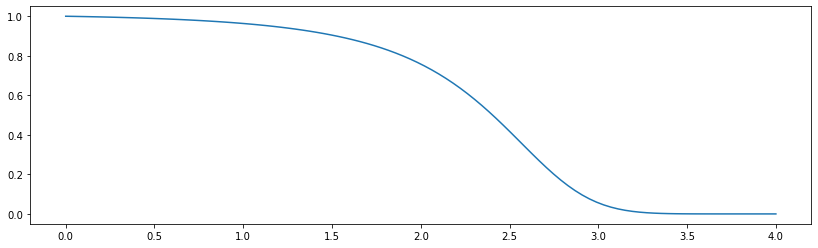

In [32]:
X = np.linspace(0, 4, 100)
y = 5 / (4 + np.exp(0.05 * np.exp(X * 1.5) - 0.05))

%matplotlib inline
plt.figure(figsize=(14,4))
plt.plot(X, y)
plt.show()

В таком случае примерно через 3 года баллы практически полностью обнулятся и не будут влиять на текущий рейтинг игрока. Но при этом, если сильный игрок пропускает несколько игр, то его рейтинг сильно не изменится.